In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load Sudoku dataset

In [29]:
imagesGrid = np.load('images_grid.npy')
labelsGrid = np.load('labels_grid.npy')


imgG = torch.tensor(imagesGrid).float().reshape((50000,1,9,9))
labG = torch.tensor(labelsGrid).float().reshape((50000,1,9,9))
imgG.shape

torch.Size([50000, 1, 9, 9])

In [30]:
trainset = torch.utils.data.TensorDataset(imgG.to(device),labG.to(device))
dataloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)

### CNN model

In [31]:
class SudokuSolverCNN(nn.Module):
    def __init__(self):
        super(SudokuSolverCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 9 * 9, 81*9)  # Output size: 81*9 to represent digits 1-9 in each cell
        self.fc2 = nn.Linear(81*9, 9 * 9 )

    def forward(self, x):
        # Input shape: N, 1, 9, 9
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 9,9)  # Reshape to N, 9, 9
        return x

In [ ]:
class SudokuSolverCNN2(nn.Module):
    def __init__(self):
        super(SudokuSolverCNN2, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 9 * 9, 81*9)  # Output size: 81*9 to represent digits 1-9 in each cell
        self.fc2 = nn.Linear(81*9, 9 * 9 * 9 )

    def forward(self, x):
        # Input shape: N, 1, 9, 9
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 9 * 9 * 9)  # Reshape to N, 9, 9
        return x

In [32]:
model = SudokuSolverCNN()
model

SudokuSolverCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5184, out_features=729, bias=True)
  (fc2): Linear(in_features=729, out_features=81, bias=True)
)

### MSE Loss with 'standard rules'

In [33]:
def SudokuLoss(out):
  N = out.shape[0]
  rows_sum_true = (torch.ones((N,9))*45).to(device)/81
  col_sum_true = (torch.ones((N,9))*45).to(device)/81
  grid_sum_true = (torch.ones((N*9))*45).to(device)/81
  rows_sum = out.sum(dim=1) / 81
  col_sum = out.sum(dim=2) / 81
  row_sum_loss = nn.MSELoss()(rows_sum_true,rows_sum)
  col_sum_loss = nn.MSELoss()(col_sum_true,col_sum)

  grid_sum = Grid_sum(out).to(device) / 81
  grid_sum_loss = nn.MSELoss()(grid_sum_true,grid_sum)
  # unique count.


  loss = grid_sum_loss + col_sum_loss + row_sum_loss

  return loss

def Grid_sum(out):
  g1 = out[:,0:3,0:3].sum(dim=1).sum(dim=1)
  g2 = out[:,3:6,0:3].sum(dim=1).sum(dim=1)
  g3 = out[:,6:9,0:3].sum(dim=1).sum(dim=1)
  g4 = out[:,0:3,3:6].sum(dim=1).sum(dim=1)
  g5 = out[:,3:6,3:6].sum(dim=1).sum(dim=1)
  g6 = out[:,6:9,3:6].sum(dim=1).sum(dim=1)
  g7 = out[:,0:3,6:9].sum(dim=1).sum(dim=1)
  g8 = out[:,3:6,6:9].sum(dim=1).sum(dim=1)
  g9 = out[:,6:9,6:9].sum(dim=1).sum(dim=1)
  return torch.cat([g1,g2,g3,g4,g5,g6,g7,g8,g9])





### Training

In [46]:
his = []
acc = []
epochs = 10
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

#criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0.0
    model.train()
    for inputs,targets in dataloader:
        optimizer.zero_grad

        outs = model(inputs/9)
        #print(outs.shape,targets.shape)

        #pred_flat = outs.view(inputs.shape[0] * 9, 81)
        #target_flat = targets.view(targets.shape[0] *9, 9)

        # Calculate cross-entropy loss
        #loss = F.cross_entropy(pred_flat, torch.argmax(target_flat, dim=1))


        loss = SudokuLoss(outs)#
        #print(loss)
        #break
        #loss = criterion(outs.reshape(outs.shape[0],1,9,9),targets)

        loss.backward()
        optimizer.step()

        total_loss+= loss.item()
        his.append(loss.item())

    avg_loss = total_loss/len(dataloader)
    print(f'loss : {avg_loss}')

loss : 0.7673509947174345
loss : 0.7633225942206809
loss : 0.750477567353212
loss : 0.7346383807299387
loss : 0.7182409190155966
loss : 0.7016831389473527
loss : 0.6850847822930807
loss : 0.6685546285965863
loss : 0.6522732902975643
loss : 0.6363849687149458


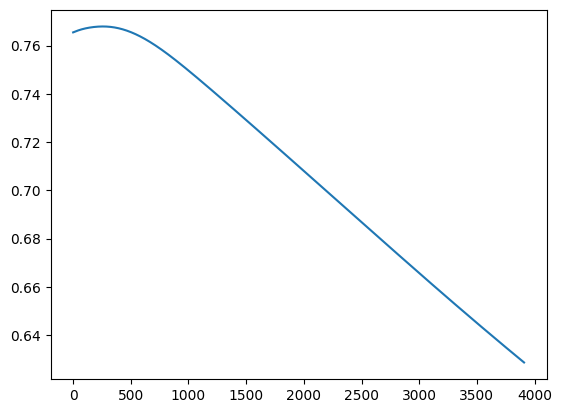

In [47]:
plt.plot(his)

In [48]:
(model(inputs[0:1]/9)).int(),targets[0:1].int()[0]

(tensor([[[0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 1, 0, 0, 1, 0, 1, 1, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 1, 0, 1, 1],
          [0, 1, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=torch.int32),
 tensor([[[7, 3, 8, 9, 5, 2, 4, 1, 6],
          [2, 1, 6, 3, 7, 4, 9, 5, 8],
          [9, 5, 4, 1, 8, 6, 4, 2, 3],
          [1, 8, 2, 6, 3, 7, 5, 9, 4],
          [6, 9, 3, 4, 1, 5, 8, 7, 2],
          [4, 7, 5, 8, 2, 9, 3, 6, 1],
          [3, 6, 7, 5, 4, 1, 2, 8, 9],
          [5, 4, 9, 2, 6, 8, 1, 3, 7],
          [8, 3, 1, 7, 9, 3, 6, 4, 5]]], dtype=torch.int32))

### Predictions for Kaggle

In [49]:
all_output = np.zeros((10000, 9, 9))
all_ids = []
images_test_grid = np.load('images_test_grid.npy')
for n in range(10000):
  input = torch.tensor(images_test_grid[n]).float().reshape((1,1, 9,9)) # shape = batch_size, number of neurons in first layer of linear model.
  output = (model(input)*9).int()
  all_output[n] = images_test_grid[n]
  for i in range(9):
    for j in range(9):
      id = f'{n}_{i}{j}'
      all_ids.append(id)
      #print(all_output[n,i,j])
      if int(all_output[n,i,j]) ==0:
        #print(all_output[n,i,j])
        all_output[n, i, j] = output[0,i,j].item()


### Training with MSE Loss

In [41]:
his1 = []
acc = []
epochs = 10
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0.0
    model.train()
    for inputs,targets in dataloader:
        optimizer.zero_grad

        outs = model(inputs/9)
        #print(outs.shape,targets.shape)


        loss = criterion(outs,targets[:,0]/9)#
        #print(loss)
        #break
        #loss = criterion(outs.reshape(outs.shape[0],1,9,9),targets)

        loss.backward()
        optimizer.step()

        total_loss+= loss.item()
        his1.append(loss.item())

    avg_loss = total_loss/len(dataloader)
    print(f'loss : {avg_loss}')

loss : 0.08315704402792484
loss : 0.08276505989339346
loss : 0.08524276935459708
loss : 0.08961268653497671
loss : 0.09412495336492958
loss : 0.09665601494748269
loss : 0.09610532071736767
loss : 0.0931994033324749
loss : 0.08763145849756572
loss : 0.0876782925232597


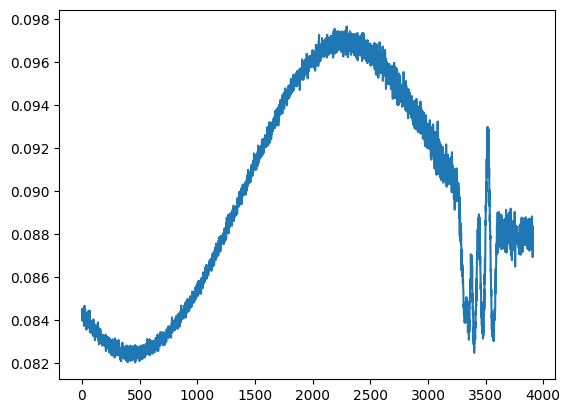

In [42]:
plt.plot(his1)

In [43]:
all_output = np.zeros((10000, 9, 9))
all_ids = []
images_test_grid = np.load('images_test_grid.npy')
for n in range(10000):
  input = torch.tensor(images_test_grid[n]).float().reshape((1,1, 9,9)) # shape = batch_size, number of neurons in first layer of linear model.
  output = (model(input)*9).int()
  all_output[n] = images_test_grid[n]
  for i in range(9):
    for j in range(9):
      id = f'{n}_{i}{j}'
      all_ids.append(id)
      #print(all_output[n,i,j])
      if int(all_output[n,i,j]) ==0:
        #print(all_output[n,i,j])
        all_output[n, i, j] = output[0,i,j].item()


### Training with Cross-Entropy Loss

In [50]:
his2 = []
acc = []
epochs = 10
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = 0.0
    model.train()
    for inputs,targets in dataloader:
        optimizer.zero_grad

        outs = model(inputs/9)
        #print(outs.shape,targets.shape)

        #pred_flat = outs.view(inputs.shape[0] * 9, 81)
        #target_flat = targets.view(targets.shape[0] *9, 9)

        # Calculate cross-entropy loss
        #loss = F.cross_entropy(pred_flat, torch.argmax(target_flat, dim=1))


        loss = criterion(outs,targets[:,0]/9)#
        #print(loss)
        #break
        #loss = criterion(outs.reshape(outs.shape[0],1,9,9),targets)

        loss.backward()
        optimizer.step()

        total_loss+= loss.item()
        his2.append(loss.item())

    avg_loss = total_loss/len(dataloader)
    print(f'loss : {avg_loss}')

loss : 11.029584628541755
loss : 11.026364045984606
loss : 11.021372680468938
loss : 11.015251193814874
loss : 11.008410412332285
loss : 11.001683083946443
loss : 10.996026861088355
loss : 10.992088217869439
loss : 10.989352582360777
loss : 10.986601600256723


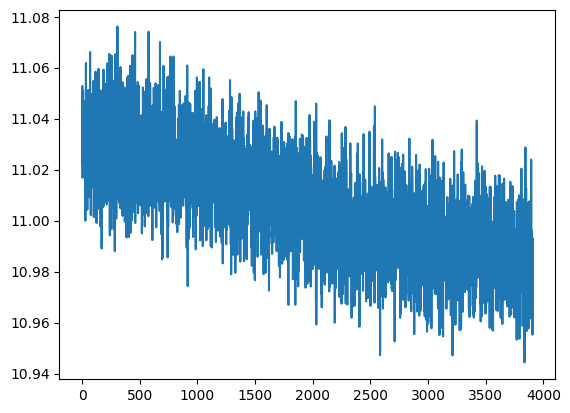

In [51]:
plt.plot(his2)

In [52]:
all_output = np.zeros((10000, 9, 9))
all_ids = []
images_test_grid = np.load('images_test_grid.npy')
for n in range(10000):
  input = torch.tensor(images_test_grid[n]).float().reshape((1,1, 9,9)) # shape = batch_size, number of neurons in first layer of linear model.
  output = (model(input)*9).int()
  all_output[n] = images_test_grid[n]
  for i in range(9):
    for j in range(9):
      id = f'{n}_{i}{j}'
      all_ids.append(id)
      #print(all_output[n,i,j])
      if int(all_output[n,i,j]) ==0:
        #print(all_output[n,i,j])
        all_output[n, i, j] = output[0,i,j].item()


In [ ]:
all_output = all_output.reshape((810000))

In [53]:
cs = {'id':all_ids,'value':all_output}
csv = pd.DataFrame(cs)

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
csv.to_csv('submissionT2.csv',index=False)